In [1]:
import os
import json
import tensorflow as tf
from src.performance import *
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from dotenv import load_dotenv

2024-09-20 00:58:21.756154: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 00:58:23.426375: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 00:58:24.422880: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 00:58:25.345230: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 00:58:25.553121: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 00:58:27.051381: I tensorflow/core/platform/cpu_feature_gu

In [2]:
env = load_dotenv()

train_path = os.getenv('TRAIN_P')
test_path = os.getenv('TEST_P')
valid_path = os.getenv('VALID_P')
model_save_resnet50 = os.getenv('MODEL_SAVE_RESNET50V2')
history_save_resnet50 = os.getenv('SAVE_HISTORY_RESNET50V2')

env

True

In [3]:
# Initialize ImageDataGenerators
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Convert Keras ImageDataGenerator to tf.data.Dataset with .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, val_generator.num_classes), dtype=tf.float32)
    )
).repeat()

# Adjust steps_per_epoch and validation_steps if necessary
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

Found 3200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [4]:
from keras.callbacks import Callback
from keras.optimizers import Adam

# Define a custom callback to adjust the learning rate based on validation accuracy
class AdjustLearningRate(Callback):
    def __init__(self, threshold=0.70, new_lr=0.00001):
        super(AdjustLearningRate, self).__init__()
        self.threshold = threshold  
        self.new_lr = new_lr        

    def on_epoch_end(self, epoch, logs=None):
       
        val_accuracy = logs.get('accuracy')
        if val_accuracy is not None and val_accuracy > self.threshold:
            current_lr = float(self.model.optimizer.learning_rate.numpy())
            

            if current_lr != self.new_lr:
                # print(f"\nValidation accuracy exceeded {self.threshold * 100:.2f}%. Changing learning rate from {current_lr} to {self.new_lr}.")
                self.model.optimizer.learning_rate = self.new_lr

In [5]:
base_model = ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(1024, activation='relu'),
    # Dropout(0.5),
    # Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Freeze the Base Model Layers Initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Checkpoint to Save the Best Model
checkpoint = ModelCheckpoint(
    model_save_resnet50,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# Early Stopping Callback to Prevent Overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True,
    verbose=0
)

# Custom Learning Rate Adjustment Callback
adjust_lr = AdjustLearningRate(threshold=0.90, new_lr=0.00001)

In [6]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[checkpoint, early_stopping, adjust_lr]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.4554 - loss: 1.1647 - val_accuracy: 0.7891 - val_loss: 0.5403
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.8318 - loss: 0.4650 - val_accuracy: 0.9158 - val_loss: 0.2903
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9447 - loss: 0.2706 - val_accuracy: 0.9402 - val_loss: 0.2110
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9537 - loss: 0.2161 - val_accuracy: 0.9484 - val_loss: 0.1930
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9600 - loss: 0.2065 - val_accuracy: 0.9538 - val_loss: 0.1797
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9593 - loss: 0.2043 - val_accuracy: 0.9674 - val_loss: 0.1697
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9529 - loss: 0.1987 - val_accuracy: 0.9565 - val_loss: 0.1701
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9639 - loss: 0.1933 - val_accu

In [7]:
# save history & final model

model.save(model_save_resnet50)

with open(history_save_resnet50, 'w') as file:
    json.dump(history.history, file)

print('model & history saved')

model & history saved


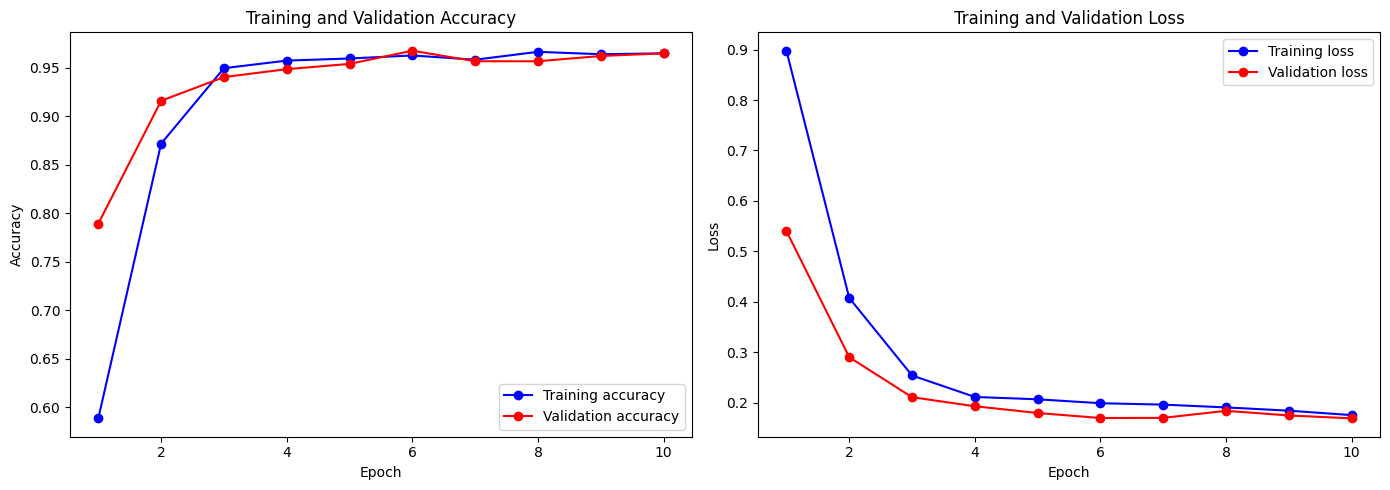

/media/X/Research_coffee_classification/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step
Confusion Matrix


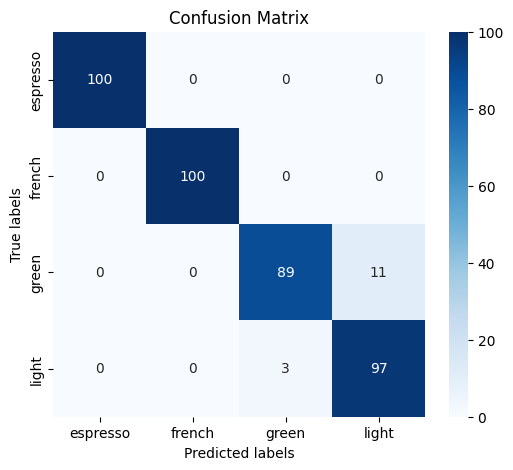

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
Classification Reports
              precision    recall  f1-score   support

    espresso       1.00      1.00      1.00       100
      french       1.00      1.00      1.00       100
       green       0.97      0.89      0.93       100
       light       0.90      0.97      0.93       100

    accuracy                           0.96       400
   macro avg       0.97      0.97      0.96       400
weighted avg       0.97      0.96      0.96       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.9833 - loss: 0.1573
Test Accuracy: 0.9649999737739563
Test Loss: 0.16272394359111786
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step


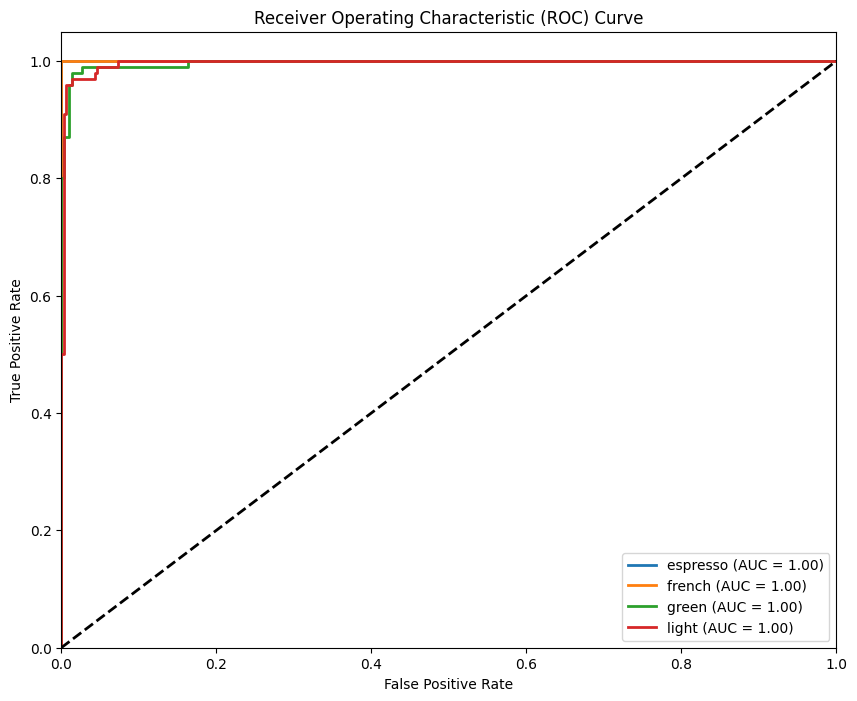

13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step
Misclassifications


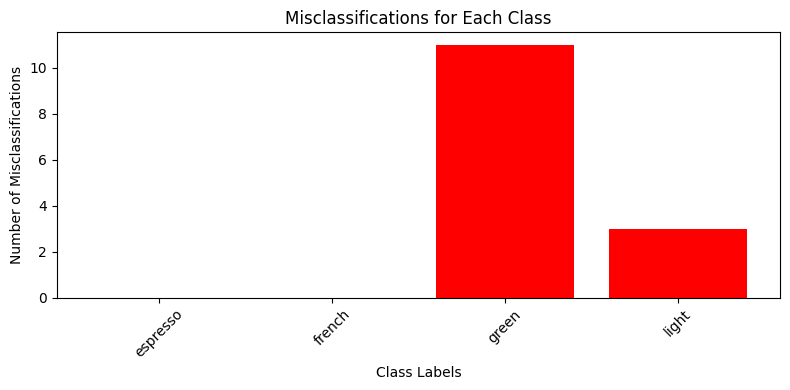

In [8]:
all_measurement(history,model,test_generator)

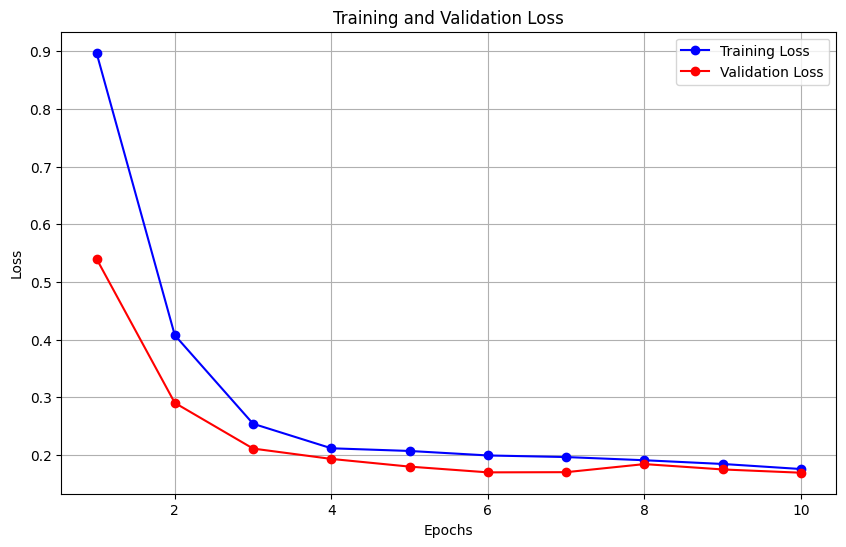

In [10]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()